In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import keras
from keras.layers import Reshape

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

Using TensorFlow backend.
c:\users\demdr\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\demdr\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\demdr\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\demdr\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [2]:
# Put here the path of the file that has the data that we will use to create predictions 

# First, we have to apply some of the functions of component 1 (all the steps) to extract some of the features 
# for activity analysis (based on analysis of accelerometer data), speed from GPS data, and POI density + traffic 
# based on the spatial database, etc.
# See the required features in the functions 'create_segments_and_labels_LAG' and 'create_segments_and_labels_for_final_prediction' here
# We can create these features using functions of component 1

# Here I am using instead a file which contains data from many participants (with features already extracted 
# after the application of methods from Component 1)
# This does not change anything; we can use either a file only from one participant, 
# or a file with combined data from multiple participants

input_data = pd.read_csv(r'C:\Users\demdr\Desktop\Testing the thesis functions\Project data\Analysed data\combined data.csv')
input_data.index = input_data['Datetime']
# Change this to another time zone if needed 
input_data.index = pd.to_datetime(input_data.index, utc=True).tz_convert('Australia/Sydney')
input_data['Datetime_from_index']= input_data.index.copy()
input_data = input_data.fillna(0)

#### Data filtering and transformations

Remove sessions where there is high speed (not corresponding to walking) for a long time, indicating that the user was moving with public transport/car:

In [3]:
df_without_high_speed = pd.DataFrame()

for user in input_data['UserID'].unique():
    # Include this in case we want to create predictions for multiple users at the same time.
    # Here I am using an example where I load initially data from many users
    # If only one user is there, there is no issue
    this_user_df = input_data[input_data['UserID']==user]
    for ses in this_user_df['Session'].unique():
        this_session = this_user_df[this_user_df['Session']==ses]
        # if less than 20% of the session involves high speed, then proceed 
        # otherwise do not include this session
        if (len(this_session[this_session['Speed']>12])/len(this_session))<0.2:
            df_without_high_speed = df_without_high_speed.append(this_session)

#### Create a copy of the df so that we can reindex it 
because if we have combined data from more than 1 users, they may have data collected at the same time, and this creates issues if the index is the datetime object.

So, we create a temporary index (integers incrementally from 0 to x=length of the df)

In [5]:
df_without_high_speed_copy = df_without_high_speed.copy()
df_without_high_speed_copy['Index']=np.arange(len(df_without_high_speed_copy))
df_without_high_speed_copy['Datetime_helper']=df_without_high_speed_copy.index.copy()
df_without_high_speed_copy.index = df_without_high_speed_copy['Index']

#### Select a user ID to create a prediction for this user
This is a unique ID which should be assigned for this user and used for all the algorithms

In [6]:
this_id = 66192854
df_for_prediction = pd.DataFrame()
df_for_prediction = df_for_prediction.append(df_without_high_speed_copy[df_without_high_speed_copy['UserID']==this_id])
df_for_prediction.index = pd.to_datetime(df_for_prediction['Datetime_helper'])

### Transform the features
- Initial df: A dataset which contains all the available data that we have, combined 

- Target df: The dataset for which we want to create predictions. It can be only one session of one participant, or many sessions of the same participant, or multiple sessions of multiple participants combined 

The Initial df gives some info regarding the reference values, because maybe the target df contains too few data with a small range (i.e. with 22-25 C temperature, while the model is trained for a larger range) and the min-max transformations may not work properly.

This is why this function also has some pre-set thresholds derived from the initial training data. 

If we want to predict values for a large dataset, and the min and max values of the dataset are similar to those derived from the initial dataset used to construct the XGBoost model, we can use normal min-max for the columns instead of the pre-set thresholds.

In [7]:
def apply_transformations(initial_df, target_df):
    # ----Log transforms 
    this_df = target_df.copy()
    to_log = ['Density','max_Density','std_Density']
    for col in to_log:
        this_df[col] = np.log(this_df[col]+1)
        
        
    # ----Remove outliers--------------
    target_columns = ['Speed_mean_30sec','Total seconds passed']
    thresholds = {'Speed_mean_30sec':10.15, 'Total seconds passed':7505}
    for col in target_columns:
        print('----'+ col + '----')
        three_quarters = initial_df[col].describe().loc['75%']
        std = initial_df[col].describe().loc['std']
        limit_from_input_data = three_quarters + std
        limit_from_data_used_in_training = thresholds[col]
        # here we use a predetermined threshold for min-max transformation of the 'total seconds passed' column
        this_limit = limit_from_data_used_in_training
        if col == 'Total seconds passed':
            print(col, ': threshold for outlier correction derived from input data:', limit_from_input_data/60, 'minutes')
            print('Threshold for training data:', limit_from_data_used_in_training/60, 'minutes')
            # Put a warning if the data to be corrected have a larger range than the data used 
            #for training the model -- this is a concern particularly for the 'Total seconds passed' column.
            # The model was trained having activities of 125-126 minutes as the highest value, 
            # and did not have enough data for predicting the signal for activities with a much higher duration than this
            if limit_from_input_data>limit_from_data_used_in_training:
                print('Warning: The input data have larger range than the data that was used for training the model-this may lead to inaccuracies and the model should be trained again to accommodate the higher range')

        else:
            print(col, ': threshold for outlier correction derived from input data:', limit_from_input_data, 'km/h')
            print(col, 'Threshold for training data:', limit_from_data_used_in_training, 'km/h')
        this_df.loc[this_df[this_df[col]>this_limit].index, col]=this_limit
        
    
    # ----Transformations for time --------------
    this_df['Total seconds passed'] = np.log(this_df['Total seconds passed']+1)
    this_df['Total seconds passed'] = np.power(this_df['Total seconds passed'], 4)
    
    time_max = this_df['Total seconds passed'].max()
    print(time_max)
    this_df['Total seconds passed'] = this_df['Total seconds passed'] / time_max
   
    # 
    # ----Other Min-max transformations --------------
    cols_for_minmax = ['activity','Change of activity state', 'Steady state',
                  'Density','max_Density','Traffic', 'Traffic signal','Speed_mean_30sec','std_Density',
                   'Significant Changes:Activity','Significant Changes:Traffic', 'Significant Changes:Density']
    # These are reference values for max values based on the initial data used for training+testing the model
    minmax_thresholds = {'activity':3,'Change of activity state':1, 'Steady state':1,
                  'Density':3.892,'max_Density':3.892,'Traffic':4, 'Traffic signal':1,'Speed_mean_30sec':10.15,'std_Density':2.84,
                   'Significant Changes:Activity':3,'Significant Changes:Traffic':3, 'Significant Changes:Density':3}
    for col in cols_for_minmax:
        # This is supposed to be a min-max transformation (the original line was the following):
        #this_max = this_df[col].max()
        # but we use the max values from the data used for training, because the input data might have lower values 
        # (for instance, it might not have any traffic signal; then the max value for this column would be 0, and 
        # the min-max transform would not have the intended result)
        # From these columns, the values related to 'Density' may be a bit different in different contexts. If 
        # they are much higher than those reported here, then this model will not be appropriate and a new model should be trained
        max_from_input_data = this_df[col].max()
        max_from_original_training_data = minmax_thresholds[col]
        print('max value from input data:', col, max_from_input_data)
        print('max value from training data:', col,  max_from_original_training_data)
        if max_from_input_data> max_from_original_training_data:
            print('WARNING: Higher values are included in the input data than those included in the original training data')
            print('Predictions may be less accurate-a new model should be constructed')
            # if that's the case, consider using the following line instead of the uncommented one:
        #this_df[col]=this_df[col]/max_from_original_training_data
        this_df[col]=this_df[col]/max_from_original_training_data
        
        
        
    # ----Min-max transformation of temperature--------------
    # The min and max temperature values for the training data were 10.5 and 32 °C--
    # The original algorithm used the 'temp_max' and 'temp_min', the actual min-max values of the input data, 
    # instead of the 'reference_temp_max' and 'reference_temp_min'
    # but if this model is used in production, and the input data has a very different range, 
    #the prediction accuracy may be worse because the values will exceed the [0,1] range
    temp_max = initial_df['Temperature'].max()
    temp_min = initial_df['Temperature'].min()
    reference_temp_max = 32
    reference_temp_min = 10.5
    print('Max and min temperature for input data:', temp_max, temp_min)

    this_df['Temperature_minmax'] = (this_df['Temperature']-reference_temp_min)/(reference_temp_max-reference_temp_min)

    this_df['Datetime_from_index']= this_df.index.copy()
    
    # ----Create an empty column to store these values --------------
    
    this_df['Past_Sum of amplitudes_log'] = 0
    
    # If we have past EDA data and we want to use it for testing the accuracy of the prediction: 
    sum_of_EDA_max = np.log(initial_df['Sum of EDA amplitudes']+1).max()
    this_df['Sum of EDA amplitudes_log'] = np.log(this_df['Sum of EDA amplitudes'].copy()+1)/sum_of_EDA_max
    # We will predict this anyway; we only have it here for future comparison of actual with predicted data
    
    return(this_df)


#### Apply the function for transforming the features
If we only have one dataset and we want to create a prediction for that, put the same dataset twice in the parenthesis.

Otherwise, if we have a larger dataset that we want to use for min-max transformation, the larger dataset can be put as the first dataframe in the parenthesis, to give information for the min-max.

In [8]:
df_test = apply_transformations(df_for_prediction.copy(), df_for_prediction)

----Speed_mean_30sec----
Speed_mean_30sec : threshold for outlier correction derived from input data: 4.511617687013182 km/h
Speed_mean_30sec Threshold for training data: 10.15 km/h
----Total seconds passed----
Total seconds passed : threshold for outlier correction derived from input data: 301.2366049781106 minutes
Threshold for training data: 125.08333333333333 minutes
6340.634678348907
max value from input data: activity 3.0
max value from training data: activity 3
max value from input data: Change of activity state 1.0
max value from training data: Change of activity state 1
max value from input data: Steady state 1.0
max value from training data: Steady state 1
max value from input data: Density 3.6109179126442243
max value from training data: Density 3.892
max value from input data: max_Density 3.6109179126442243
max value from training data: max_Density 3.892
max value from input data: Traffic 4.0
max value from training data: Traffic 4
max value from input data: Traffic signal 

In [9]:
# Fill missing values
for i in df_test.isnull().any().index:
    if df_test.isnull().any().loc[i]==True:
        df_test = df_test.fillna(0)

### Function for predicting the lag EDA data
- We use this function to create a prediction for a 240s window 
- Then we will use this feature as input (as a lag feature derived from the previous time window) for the final prediction 


- Alternatively, we could retrain the model so that it does not use the predicted lag feature as input. In this case, we could skip this step and jump directly to the function 'create_segments_and_labels_for_final_prediction'. We would have to modify slightly that function in the following way: remove the feature 'Past_Sum of amplitudes_log' from that function, and declare that we have N_FEATURES=19, and not 20. The model would have to be retrained using the 19 features and not the 20 that it uses now.

In [10]:
# 240 corresponds to a time window of 240 seconds
TIME_PERIODS = 240
STEP_DISTANCE= 240

def create_segments_and_labels_LAG(df, time_steps, step):

    N_FEATURES = 19
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        mean_de = df['Density'].values[i: i+ time_steps]
        std_de = df['std_Density'].values[i: i+ time_steps]
        activity_state_change = df['Change of activity state'].values[i: i + time_steps]
        steady = df['Steady state'].values[i: i + time_steps]
        steady_diff = np.insert(np.diff(df['Steady state'].values[i: i+ time_steps]), 0, 0)

        
        
        current_ac = df['activity'].values[i: i + time_steps]
        act_diff = np.insert(np.diff(df['activity'].values[i: i + time_steps]), 0, 0)
        activity_change = df['Significant Changes:Activity'].values[i: i + time_steps]
        traffic_change = df['Significant Changes:Traffic'].values[i: i+ time_steps]
        density_change = df['Significant Changes:Density'].values[i: i+ time_steps]
        traffic = df['Traffic'].values[i: i+ time_steps]
        
        time = np.power(df['Total seconds passed'].values[i: i+ time_steps], 1)
        speed = df['Speed_mean_30sec'].values[i: i+ time_steps]
        tr_light = df['Traffic signal'].values[i: i+ time_steps]

        temperat = df['Temperature_minmax'].values[i: i+ time_steps]
        
        
        # find time passed since the beginning of the activity
        ses = df['Session'].values[i]
        this_session = df[df['Session']==ses]
        this_index = this_session.loc[df.index[i], 'Datetime_from_index']
        index_0 = this_session.loc[this_session.index[0], 'Datetime_from_index']
        time_passed = (this_index-index_0).total_seconds()

        # Create empty arrays that will be then filled with features for the previous time window
        # previous activity
        prev_ac = np.full(current_ac.shape, 0)
        # previous density
        prev_den = np.full(current_ac.shape, 0)
        # previous traffic light
        prev_signal = np.full(current_ac.shape, 0)
        # previous speed
        prev_speed = np.full(current_ac.shape, 0)
        
        # if we are not in the first time window (the first 240 seconds) of this activity session, proceed 
        # and compute the features for the previous time window 
        if i>TIME_PERIODS:
            if time_passed>TIME_PERIODS:
                prev_ac = df['activity'].values[i-TIME_PERIODS: i]
                prev_speed = df['Speed_mean_30sec'].values[i-TIME_PERIODS: i]
                prev_den = df['Density'].values[i-TIME_PERIODS: i]
                prev_signal = df['Traffic signal'].values[i-TIME_PERIODS: i]
        # else just keep the array filled with zeros
        else:
            prev_ac = np.full(current_ac.shape, 0)
            prev_den = np.full(current_ac.shape, 0)
            prev_signal = np.full(current_ac.shape, 0)
            
            
               
        

        feature_list = [current_ac,activity_change,
                         density_change, traffic_change, traffic,
                         time, tr_light, speed,
                        prev_ac, prev_den,prev_signal, 
                           mean_de, std_de, activity_state_change, steady,
                            steady_diff, act_diff, prev_speed,temperat
                            ]


        segments.append(feature_list)
        

        

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)


    return reshaped_segments
    

#### To use the function above, load the created model for prediction of the lag feature

In [11]:
xgb_LAG = XGBRegressor()
xgb_LAG.load_model(r'model_for_prediction_of_lag_feature.h5')

### Use the model loaded above to predict the lag feature

In [12]:
x_test_LAG = create_segments_and_labels_LAG(df_test,
                                            240,
                                            240
                                            )
num_time_periods, num_sensors = x_test_LAG.shape[1], x_test_LAG.shape[2]
input_shape = (num_time_periods*num_sensors)

# Reshape the array with the features, so that we can use it as input for the prediction model
x_test_LAG = x_test_LAG.reshape(x_test_LAG.shape[0], input_shape)
x_test_LAG = x_test_LAG.astype('float32')


prediction_LAG = xgb_LAG.predict(x_test_LAG)
# time window: 240 seconds
TIME_PERIODS = 240
STEP_DISTANCE= 240

def create_EDA_LAG_from_predicted(df, time_steps, step):

    cnt=0
    for i in range(0, len(df) - time_steps, step):
        predicted_EDA = prediction_LAG[cnt]
        cnt+=1
        if cnt<len(df_test):
            df.loc[i: i+ time_steps, 'Past_Sum of amplitudes_log']=predicted_EDA
# Predict the lag feature
create_EDA_LAG_from_predicted(df_test, TIME_PERIODS, STEP_DISTANCE)




c:\users\demdr\python37\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


### Definition for final prediction of the signal 

In [13]:
TIME_PERIODS = 240
STEP_DISTANCE= 240

def create_segments_and_labels_for_final_prediction(df, time_steps, step):


    N_FEATURES = 20

    segments = []
    for i in range(0, len(df) - time_steps, step):
        mean_de = df['Density'].values[i: i+ time_steps]
        std_de = df['std_Density'].values[i: i+ time_steps]
        activity_state_change = df['Change of activity state'].values[i: i + time_steps]
        steady = df['Steady state'].values[i: i + time_steps]
        steady_diff = np.insert(np.diff(df['Steady state'].values[i: i+ time_steps]), 0, 0)
        

        current_ac = df['activity'].values[i: i + time_steps]
        act_diff = np.insert(np.diff(df['activity'].values[i: i + time_steps]), 0, 0)

        activity_change = df['Significant Changes:Activity'].values[i: i + time_steps]
        traffic_change = df['Significant Changes:Traffic'].values[i: i+ time_steps]
        density_change = df['Significant Changes:Density'].values[i: i+ time_steps]
        traffic = df['Traffic'].values[i: i+ time_steps]
        time = np.power(df['Total seconds passed'].values[i: i+ time_steps], 1)
        speed = df['Speed_mean_30sec'].values[i: i+ time_steps]
        tr_light = df['Traffic signal'].values[i: i+ time_steps]

        
        temperat = df['Temperature_minmax'].values[i: i+ time_steps]
        
        # find time passed since the beginning of the activity
        ses = df['Session'].values[i]
        this_session = df[df['Session']==ses]
        this_index = this_session.loc[df.index[i], 'Datetime_from_index']
        index_0 = this_session.loc[this_session.index[0], 'Datetime_from_index']
        time_passed = (this_index-index_0).total_seconds()
        
        # Create empty arrays that will be then filled with features for the previous time window
        # previous activity
        prev_ac = np.full(current_ac.shape, 0)
        # previous density
        prev_den = np.full(current_ac.shape, 0)
        # previous signal
        prev_signal = np.full(current_ac.shape, 0)
        # previous speed
        prev_speed = np.full(current_ac.shape, 0)
        
        
        if i>TIME_PERIODS:
            if time_passed>TIME_PERIODS:
                prev_ac = df['activity'].values[i-TIME_PERIODS: i]
                prev_speed = df['Speed_mean_30sec'].values[i-TIME_PERIODS: i]
                prev_den = df['Density'].values[i-TIME_PERIODS: i]
                prev_signal = df['Traffic signal'].values[i-TIME_PERIODS: i]
                
        else:
            prev_ac = np.full(current_ac.shape, 0)
            prev_den = np.full(current_ac.shape, 0)
            prev_signal = np.full(current_ac.shape, 0)
            
            
        # Add the lagged feature that was created with the prediction model above
        prev_EDA=0
        if i>180:
            prev_EDA = np.full(current_ac.shape, df['Past_Sum of amplitudes_log'].values[i-60 : i].mean())
        else:
            prev_EDA = np.full(current_ac.shape, 0)


        feature_list_small = [current_ac,activity_change,
                         density_change, traffic_change, traffic,
                         time, tr_light, speed,
                        prev_ac, prev_den,prev_signal, 
                           mean_de, std_de, activity_state_change, steady,
                            steady_diff, act_diff, prev_speed,temperat, prev_EDA
                            ]


        segments.append(feature_list_small)
        

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
  

    return reshaped_segments
  


#### Load the created model for prediction of the final feature

In [14]:
xgb_regressor = XGBRegressor()
xgb_regressor.load_model(r'model_for_regression_of_log_Sum_of_EDR_amplitudes_240s.h5')

### Use the xgboost model to create the final prediction

In [15]:
# Create the array with the features that will be used as input
final_x_test= create_segments_and_labels_for_final_prediction(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE
                                            )
# Reshape the array
num_time_periods, num_sensors = final_x_test.shape[1], final_x_test.shape[2]
input_shape = (num_time_periods*num_sensors)
final_x_test = final_x_test.reshape(final_x_test.shape[0], input_shape)
final_x_test = final_x_test.astype('float32')

# Create the prediction
predicted_log_of_signal = xgb_regressor.predict(final_x_test)


### Reverse the log transform to find the actual signal

In [16]:
# Reference values for the original data used for training and testing the algorithm:

# df_without_high_speed['Sum of EDR amplitudes'].copy()=8.16
# The formula which was originally used for the EDA max, during the construction of the model, was the following:
#this_EDA_max = np.log(df_without_high_speed['Sum of EDR amplitudes'].copy()+1).max()
# Here we use directly the value derived from this computation, based on the original training and testing data 
this_EDA_max = 2.21
# The extraction of the max of the log was based on 
# the following max value: df_without_high_speed['Sum of EDR amplitudes'].max()=8.16
# If the same process is followed to train a new model, use the formula to find the 'this_EDA_max' value for this model
# instead of the value used here (2.21)
final_signal = np.exp(predicted_log_of_signal*this_EDA_max)-1

### Put the values in the original 1-second resampling
(In the array with the predictions, 1 value corresponds to 240s time window)

In [17]:
def put_predicted_values_in_original_dataframe(this_df, time_steps, step):
    this_df_copy = this_df.copy()
    # This is for storing the values with the log transform
    this_df_copy['Predicted_Sum of amplitudes_log']=0
    # This is to store the values after reversing the log transform
    this_df_copy['Predicted_Sum of amplitudes_after transform']=0
    this_df_copy.index = np.arange(len(this_df_copy))
    cnt=0
    for i in range(0, len(this_df_copy) - time_steps, step):
        # PUT HERE THE LOG TRANSFORMED
        predicted_final_signal_with_log = predicted_log_of_signal[cnt]
        predicted_final_signal_without_log = final_signal[cnt]
        cnt+=1
        if cnt<len(this_df_copy):
            this_df_copy.loc[this_df_copy.index[i]: this_df_copy.index[i+ time_steps], 'Predicted_Sum of amplitudes_log']=predicted_final_signal_with_log
            this_df_copy.loc[this_df_copy.index[i]: this_df_copy.index[i+ time_steps], 'Predicted_Sum of amplitudes_after transform']=predicted_final_signal_without_log
    
    return(this_df_copy)
    
test_df_copy = put_predicted_values_in_original_dataframe(df_test, TIME_PERIODS, STEP_DISTANCE)
# The final column for storing the values with the log transform
df_test['Predicted_Sum of amplitudes_log'] = test_df_copy['Predicted_Sum of amplitudes_log'].values.copy()
# The final column for storing the values after reversing the log transform
# THIS IS THE COLUMN CONTAINING THE END RESULT OF THIS ALGORITHM - THE PREDICTED DATA
df_test['Predicted_Sum of amplitudes_after transform'] = test_df_copy['Predicted_Sum of amplitudes_after transform'].values.copy()


## Extra: If we have available EDA data and we want to use the model for testing its accuracy
This can only be used if we are testing the accuracy of the model and we have available EDA data which has been processed to extract the sum of EDR amplitude data.

First, generate an array with the means of the actual values for each time window.

The array will be then used for comparison with the predicted ones, if we have this data.

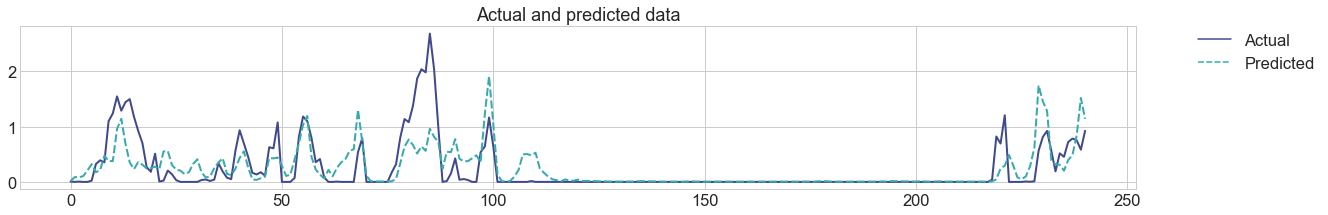

In [19]:
def get_original_values_for_comparison(this_df, time_steps, step):
    this_df_copy = this_df.copy()
    this_df_copy['Mean values without log']=0
    this_df_copy.index = np.arange(len(this_df_copy))
    cnt=0
    actual_values = []
    for i in range(0, len(this_df_copy) - time_steps, step):
        label_c = this_df_copy['Sum of EDR amplitudes'].values[i: i+ time_steps].mean()
        actual_values.append(label_c)
        cnt+=1
    return(actual_values)
original_values_without_log = get_original_values_for_comparison(df_test, TIME_PERIODS, STEP_DISTANCE)





# After using the helper function, we generate a df ('for_plot') that we will use to plot the predicted signal (after the transformation) and the actual values for comparison

# Option 1: Use this is to compare the actual and predicted values for the ORIGINAL df, with 1-second resampling(where each value corresponds to 1 second)
'''
for_plot= pd.DataFrame()
#for_plot['Actual']=df_test['Sum of EDR amplitudes_log']
#for_plot['Predicted_XGBoost_with lag']=df_test['Predicted_Sum of amplitudes_log']
for_plot['Actual']=df_test['Sum of EDR amplitudes']
for_plot['Predicted_XGBoost_with lag']=df_test['Predicted_Sum of amplitudes_after transform']
for_plot.index = np.arange(len(for_plot))
for_plot
'''

# Option 2: Use this is to compare the actual and predicted values for the RESAMPLED df (where 1 time window corresponds to 240 seconds and is connected with 1 predicted value)
for_plot= pd.DataFrame()
for_plot['Actual']=original_values_without_log
for_plot['Predicted']=final_signal
for_plot

# Finally, plot the predicted data against the actual values 
# Use a different step if needed, according to the quantity of the data 
# (step=10000) was used to compare predicted and actual values for a df_test with 116102 rows
step = 10000
sns.set_context('notebook',font_scale=1.5)
plt.style.use('seaborn-whitegrid')
palette = sns.color_palette("mako", len(for_plot.columns))

for i in range(0,len(for_plot), step):
    plt.figure(figsize=(20,3))
    sns.lineplot(data=for_plot[i:i+step],palette=palette, style='choice', linewidth=2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Actual and predicted data')